In [1]:
from PIL import Image
import os
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image
from sklearn.cluster import KMeans
import pandas as pd
from scipy.ndimage import interpolation as inter
import tqdm
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import torch
import xml.etree.ElementTree as ET

C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Load 

In [2]:
model_path = r"C:\Users\merse\Desktop\Tablature OCR\model\model2.pth"
model = core.Model.load(model_path, ["p", "i", "m", "a", "1", "2", "3", "4"])

### Select Image

In [3]:
path_to_img = r"C:\Users\merse\Desktop\Tablature OCR\scannedTests\test_images\8rotated2.jpg"

### Select input

In [4]:
# NOTES = 1,2,3,4,5,6.. = labels with integers
# FINGERING = p,i,m,a   = labels with strings

string_number = 6
note_number = 8
fingering_number = 20
chord_number = 20

header_number = 8
header_existence = True
note_string_existence = True
note_strings = [1]

### Detect horizontal lines

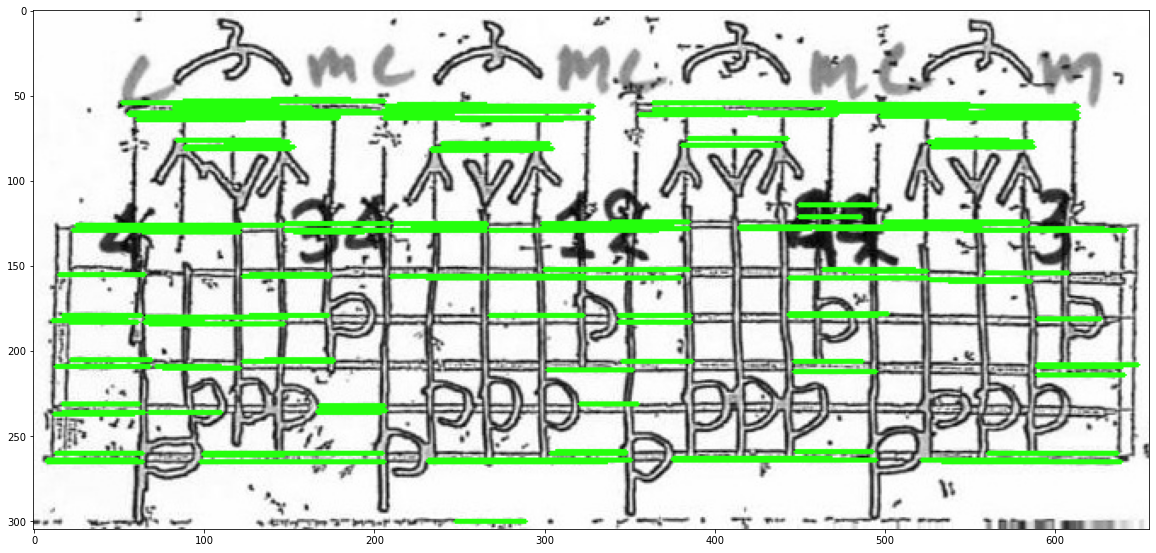

In [5]:
# Load image, convert to grayscale, Otsu's threshold
image = cv2.imread(path_to_img)
imgCp = image.copy()
gray = cv2.cvtColor(imgCp,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Detect horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
horizontalContours = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
horizontalContours = horizontalContours[0] if len(horizontalContours) == 2 else horizontalContours[1]
for hc in horizontalContours:
    cv2.drawContours(imgCp, [hc], -1, (36,255,12), 2)
plt.figure(figsize=(20, 20))
plt.imshow(imgCp)

### Create df and sort contours

In [6]:
df = pd.DataFrame(np.vstack(np.concatenate(horizontalContours)), columns=['x', 'y'])
sorted_df = df.sort_values('y',ignore_index=True)

### In case there are lines at the top or bottom, use the code below to remove them from the df

In [7]:
# REMOVE UPPER LINE
#sorted_df = sorted_df[sorted_df["y"]>20]

# REMOVE LOWER LINE
#sorted_df = sorted_df[sorted_df["y"]< 280]

### Find centroids with K-Means

In [8]:
cluster_number = string_number + 2
X = sorted_df[["y"]]
kmeans = KMeans(n_clusters=cluster_number, random_state = 0).fit(X)
centroids = np.copy(kmeans.cluster_centers_)
sorted_centroids = np.sort(centroids, axis = 0)

classes = sorted_centroids.flatten().tolist()
# If the number of centroides is 8 then remove the second one because it's the beam.
# Keep header and strings
if len(classes) == cluster_number:
    classes.pop(1)
classes

C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[58.73863636363653,
 126.68115942028986,
 155.57142857142858,
 180.8181818181818,
 208.43333333333334,
 234.5263157894737,
 264.35555555555567]

### Model Detection

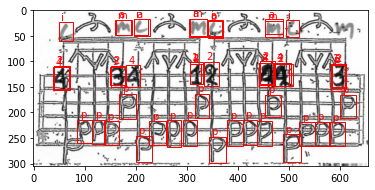

In [9]:
thresh = 0
predictions = model.predict(image)
labels, boxes, scores = predictions
filtered_indices = np.where(scores > thresh)
filtered_scores = scores[filtered_indices]
filtered_boxes = boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)

### Create a dataframe with the information

In [10]:
mdf = pd.DataFrame(filtered_boxes.numpy(), columns = ["x1", "y1", "x2", "y2"])
mdf['Label'] = pd.Series(filtered_labels)
mdf['Score'] = pd.Series(filtered_scores)

# Bring label to the front
col = mdf.pop("Label")
mdf.insert(0, col.name, col)

# Find the centroids
mdf['Centroid x'] = abs(mdf['x2'] - mdf['x1'])/2 + mdf['x1']
mdf['Centroid y'] = abs(mdf['y2'] - mdf['y1'])/2 + mdf['y1']

# If the label is p then the centroid of Y is higher to 2/3 of the main cetroid
mdf.loc[mdf['Label'] == "p", 'Centroid y'] = abs(mdf['y2'] - mdf['y1'])/3 + mdf['y1']

### Find the classes (strings or header) of the detected symbols (labels)

In [11]:
for element, row in mdf.iterrows():
    found = min(classes, key = lambda x:abs(x-mdf.loc[element, "Centroid y"]))    
    mdf.loc[element, "String"] = int(classes.index(found))
    
mdf["String"] = mdf["String"].astype(int)
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [12]:
mdf.sort_values(by='Centroid x', ascending=True)

,Label,x1,y1,x2,y2,Score,Centroid x,Centroid y,String
12,4,38.182800,111.404297,68.785690,156.737045,0.862307,53.484245,134.070679,1
15,1,40.115067,108.232117,69.671890,153.143524,0.467270,54.893478,130.687820,1
47,2,39.380154,108.867393,71.091164,156.573380,0.106969,55.235657,132.720383,1
5,i,49.268242,23.679636,77.229935,59.188484,0.969820,63.249088,41.434059,0
36,p,85.305847,214.973679,113.794250,259.327972,0.157765,99.550049,229.758438,5
16,p,114.723007,214.334579,140.246933,260.840240,0.420347,127.484970,229.836472,5
29,p,138.668640,217.330597,168.342056,263.501068,0.207998,153.505341,232.720749,5
10,3,149.938370,109.995674,179.146225,146.817337,0.925733,164.542297,128.406509,1
25,2,151.198471,108.157776,179.884705,149.880203,0.270580,165.541595,129.018982,1
13,m,158.944687,19.512220,191.779236,48.219814,0.808025,175.361969,33.866016,0


### Eliminate very close elements

In [13]:
# Copy df to avoid destroying the main one
mdf = mdf.sort_values(by='Centroid x', ascending=True).reset_index(drop=True)
# Find the mean distance between detected (and possibly wrong) items
distances = []
for item, row in mdf.iloc[1:].iterrows():
    distances.append(abs(mdf.loc[item,"Centroid x"] - mdf.loc[item - 1,"Centroid x"]))
mean_distance = sum(distances)/len(distances)
print("mean dist:", mean_distance)

# Erase close elements
item = 1
previous_item =[0]
try:
    while item <= mdf.shape[0]:
        diff = abs(mdf.loc[item,"Centroid x"] - mdf.loc[previous_item[-1],"Centroid x"])

        if (diff < (mean_distance/2)) and (mdf.loc[item,"String"] == mdf.loc[previous_item[-1],"String"]):
            print("diff: ", diff, " mean dist / 2 : ", mean_distance/2)
            if mdf.iloc[item,5] >= mdf.iloc[previous_item[-1],5]:
                mdf = mdf.drop(previous_item[-1]).reset_index(drop=True)
            else:
                mdf = mdf.drop(item).reset_index(drop=True)

        else:
            previous_item.append(item)
            item += 1
except:
    pass

mean dist: 11.018025865741805
diff:  1.4092331  mean dist / 2 :  5.5090129328709025
diff:  1.7514114  mean dist / 2 :  5.5090129328709025
diff:  0.9992981  mean dist / 2 :  5.5090129328709025
diff:  1.1809235  mean dist / 2 :  5.5090129328709025
diff:  1.3712769  mean dist / 2 :  5.5090129328709025
diff:  2.1463928  mean dist / 2 :  5.5090129328709025
diff:  0.044006348  mean dist / 2 :  5.5090129328709025
diff:  1.1763916  mean dist / 2 :  5.5090129328709025
diff:  2.3486328  mean dist / 2 :  5.5090129328709025
diff:  0.032043457  mean dist / 2 :  5.5090129328709025
diff:  0.36270142  mean dist / 2 :  5.5090129328709025
diff:  1.9946594  mean dist / 2 :  5.5090129328709025
diff:  0.19000244  mean dist / 2 :  5.5090129328709025
diff:  1.5351562  mean dist / 2 :  5.5090129328709025
diff:  3.7473755  mean dist / 2 :  5.5090129328709025
diff:  0.29193115  mean dist / 2 :  5.5090129328709025
diff:  0.11193848  mean dist / 2 :  5.5090129328709025
diff:  1.7079468  mean dist / 2 :  5.5090129

### Eliminate the unnecessary elements  according to input

In [14]:
def remove_rows(main_df, rows_to_keep, index_start):
    delete_indexes = rows_to_keep.iloc[index_start:].index.tolist()
    main_df = main_df.drop(delete_indexes).reset_index(drop=True) 
    return main_df
    


    
# sort values by score
mdf.sort_values(by='Score', ascending=False)

try:
    # HEADER TREATMENT HERE-----------------------------------------------------------------
    # IF HEADER DOESN'T EXIST, REMOVE THE HYPOTHETICAL DETECTED ITEMS
    if not header_existence:
        mdf = mdf[mdf["String"] != 0].reset_index(drop=True)
    else:
        # IF HEADER EXISTS
        # IN CASE THERE ARE DETECTED INTEGERS AT HEADER, DELETE THEM
        rows_with_int_at_header = mdf.index[(mdf['String'] == 0) & (mdf["Label"].astype(str).str.isdigit())].tolist()
        mdf = mdf.drop(mdf.index[rows_with_int_at_header]).reset_index(drop=True)
        
        # Remove extra header notes
        header_notes_df = mdf[mdf["String"] == 0]
        mdf = remove_rows(mdf, header_notes_df, header_number)


    
    # Remove extra notes
    notes_df = mdf[mdf["Label"].astype(str).str.isdigit()]
    mdf = remove_rows(mdf, notes_df, note_number)

    # FINGERING
    ### If there's a note string(s), keep only the notes there and delete the fingering
    if note_string_existence:
        for fs in note_strings:
            # Select the fingering string and all the labels that are not integers, meaning string symbols
            strings_on_fingering = mdf[(mdf["String"]== fs) & (~mdf["Label"].astype(str).str.isdigit())].index.tolist()
            # Drop them
            mdf = mdf.drop(mdf.index[strings_on_fingering]).reset_index(drop=True)
    
    
    # Remove extra fingering
    fingering_df = mdf[~mdf["Label"].astype(str).str.isdigit() & (mdf['String'] != 0)]
    mdf = remove_rows(mdf, fingering_df, fingering_number)
    
    
    
except:
    pass

# Sort according to Centroid x
mdf = mdf.sort_values(by='Centroid x', ascending = True).reset_index(drop=True)
mdf

,Label,x1,y1,x2,y2,Score,Centroid x,Centroid y,String
0,4,38.182800,111.404297,68.785690,156.737045,0.862307,53.484245,134.070679,1
1,i,49.268242,23.679636,77.229935,59.188484,0.969820,63.249088,41.434059,0
2,p,85.305847,214.973679,113.794250,259.327972,0.157765,99.550049,229.758438,5
3,p,114.723007,214.334579,140.246933,260.840240,0.420347,127.484970,229.836472,5
4,p,138.668640,217.330597,168.342056,263.501068,0.207998,153.505341,232.720749,5
5,3,149.938370,109.995674,179.146225,146.817337,0.925733,164.542297,128.406509,1
6,m,158.944687,19.512220,191.779236,48.219814,0.808025,175.361969,33.866016,0
7,p,167.621902,164.193649,200.248032,213.579773,0.206488,183.934967,180.655685,3
8,4,182.037354,107.479683,208.599152,150.378372,0.979442,195.318253,128.929031,1
9,i,196.264267,17.362469,225.015762,47.515179,0.954911,210.640015,32.438824,0


## Build the chord sequence

### Find the position of the elements in the chord sequence

In [15]:
# copy the main df to change the centroids temporary because of p positioning
centroid_df = mdf.copy()
## Reduce the X centroid of p because it's leaning to the right
centroid_df.loc[centroid_df['Label'] == "p", 'Centroid x']= centroid_df["Centroid x"] - abs(centroid_df["x1"]-centroid_df["x2"])/4

### Chord step identification with K-means

In [16]:
X_chords = centroid_df[["Centroid x"]]
kmeans_chords = KMeans(n_clusters=chord_number, random_state = 0).fit(X_chords)
centroids_chords = np.copy(kmeans_chords.cluster_centers_)
sorted_centroids_chords = np.sort(centroids_chords, axis = 0)

chord_positions = sorted_centroids_chords.flatten().tolist()
chord_positions

C:\Users\merse\anaconda3\envs\ocr\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[58.366668701171875,
 92.42794799804688,
 121.10398864746094,
 146.0869903564453,
 171.89422607421875,
 204.7227020263672,
 234.9427947998047,
 267.4848937988281,
 299.989501953125,
 321.4319763183594,
 352.3570556640625,
 387.3666076660156,
 417.12615966796875,
 445.384765625,
 463.7791748046875,
 497.9314270019531,
 528.33154296875,
 558.504638671875,
 592.161865234375,
 607.5277099609375]

In [17]:
for item, row in centroid_df.iterrows():
    item_found = min(chord_positions, key = lambda x:abs(x-centroid_df.loc[item, "Centroid x"]))
    # Assign the position in the main df, not the temporary one
    mdf.loc[item, "Position"] = int(chord_positions.index(item_found))

mdf["Position"] = mdf["Position"].astype(int)
measureDF = mdf[["Label", "String", "Position"]]

In [21]:

measureDF

,Label,String,Position
0,4,1,0
1,i,0,0
2,p,5,1
3,p,5,2
4,p,5,3
5,3,1,4
6,m,0,4
7,p,3,4
8,4,1,5
9,i,0,5


### Test the accuracy of detection

String detected:  1          Position:   15          Score: 0.9536395072937012


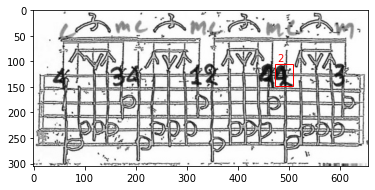

In [19]:
element = 26
# Centroid x: \033[91m \033[1m {mdf.loc[element, 'Centroid x']} \033[0m \
print(f"String detected: \033[91m \033[1m{mdf.loc[element, 'String']}\033[0m  \
        Position: \033[91m \033[1m {mdf.loc[element, 'Position']} \033[0m \
        Score: {mdf.loc[element, 'Score']}")

show_labeled_image(image, torch.tensor(mdf.iloc[element, 1:5]), mdf.loc[element, "Label"])